<a href="https://colab.research.google.com/github/mz-zarei/Trajectory_Analysis/blob/main/TrajCNNGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries - Select Device**

In [2]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim
import torch.utils.data as data_utils
import numpy as np 
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(device)

cuda


# **Load Data**

In [2]:
BS_size = 50

# Load preprocessed dataset
preprocessed_data = np.load("/content/drive/MyDrive/Trajectory_Analysis/Interaction/preprocessed_data_rot_360.npy")
# Seperate trajectories to x(first 10 frames) and y(last 10 frames)
x_data = preprocessed_data[:,:,:,:10]
y_data = preprocessed_data[:,:2,:,10:]
# Split train/validation/test sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Train data loader
train_data = data_utils.TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).float())
train_loader = data_utils.DataLoader(train_data, batch_size=BS_size, shuffle=True)
# Test data loader
test_data = data_utils.TensorDataset(torch.Tensor(X_test).float(), torch.Tensor(y_test).float())
test_loader = data_utils.DataLoader(test_data, batch_size=BS_size, shuffle=True)
# Validation data loader
val_data = data_utils.TensorDataset(torch.Tensor(X_val).float(), torch.Tensor(y_val).float())
val_loader = data_utils.DataLoader(val_data, batch_size=BS_size, shuffle=True)


# **Define Generator and Discriminator**

In [288]:
class GeneratorModel(nn.Module):
    def __init__(self, start_filter_num=4):
        '''
        Initializer function
        args: Training arguments
        infer: Training or test time (true if test time)
        '''
        super(GeneratorModel, self).__init__()

        self.start_filter_num = start_filter_num 



        self.Vconv1 = self.v_conv_layer_set(4, self.start_filter_num)
        self.Vconv2 = self.v_conv_layer_set(self.start_filter_num, self.start_filter_num*2)
        self.Vconv3 = self.v_conv_layer_set(self.start_filter_num*2, self.start_filter_num*4)
        self.Vconv4 = self.v_conv_layer_set(self.start_filter_num*4, self.start_filter_num*8)
        self.Vconv5 = self.v_conv_layer_set(self.start_filter_num*8, self.start_filter_num*16)
        self.Vconv6 = nn.Conv2d(self.start_filter_num*16, self.start_filter_num*32, 
                                kernel_size=(3, 1), padding=(1,0), bias=False)

        self.Hconv1 = self.h_conv_layer_set(4, self.start_filter_num)
        self.Hconv2 = self.h_conv_layer_set(self.start_filter_num, self.start_filter_num*2)
        self.Hconv3 = self.h_conv_layer_set(self.start_filter_num*2, self.start_filter_num*4)
        self.Hconv4 = self.h_conv_layer_set(self.start_filter_num*4, self.start_filter_num*8)
        self.Hconv5 = self.h_conv_layer_set(self.start_filter_num*8, self.start_filter_num*16)
        self.Hconv6 = nn.Conv2d(self.start_filter_num*16, self.start_filter_num*32, 
                                kernel_size=(1, 3), padding=(0,1), bias=False) 
 
        
        self.fc1 = nn.Linear(self.start_filter_num*32*2, 2)
        self.Tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(p=0.3)


    def v_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(1, 3), padding=(0,1), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2)
        )
        return conv_layer

    def h_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3, 1), padding=(1,0), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2)
        )
        return conv_layer

    def forward(self, past_traj, z):
        """
        z: uniform noise [0,1] with shape of (batch,1,36,10)
        past_traj: past traj with shape of (batch,3,36,10)
        """
        input = torch.cat([past_traj,z], 1) # -> batch_size * (1+3=4) * 36 * 10

        Voutput = self.dropout(self.Vconv1(input))    
        Voutput = self.Vconv2(Voutput)  
        Voutput = self.Vconv3(Voutput)  
        Voutput = self.Vconv4(Voutput)  
        Voutput = self.Vconv5(Voutput)  
        Voutput = self.dropout(self.Vconv6(Voutput))  

        Houtput = self.dropout(self.Hconv1(input))       
        Houtput = self.Hconv2(Houtput)  
        Houtput = self.Hconv3(Houtput)  
        Houtput = self.Hconv4(Houtput) 
        Houtput = self.Hconv5(Houtput)  
        Houtput = self.dropout(self.Hconv6(Houtput)) 

        output = torch.cat([Voutput,Houtput], 1)   # -> BS * C * H(36) * W(10)
        output = torch.transpose(output,1,3)       # -> BS * W(10) * H(36) * C
        output = self.Tanh(self.fc1(output))       # -> BS * W(10) * H(36) * 2 
        output = torch.transpose(output,1,3)       # -> BS * 2 * H(36) * W(10) same as y_train[0].shape
        return output.to(device)

class GeneratorModel(nn.Module):
    """ G(x) """
    def __init__(self, embedding_size, input_size, output_size):   
        '''
        Initializer function
        '''
        super(GeneratorModel, self).__init__()
        self.embedding_size = embedding_size
        self.input_size = input_size                                   # means the input sequence length
        self.output_size = output_size

        self.input_embedding_layer = nn.Linear(1, self.embedding_size) # assume embedding_size = 32

        self.conv1 = nn.Conv2d(in_channels = self.input_size, out_channels = 2*self.input_size, kernel_size = 3, padding = (0,2), dilation=2)
        self.bn1 = nn.BatchNorm2d(2*self.input_size)                   # padding 1 to keep the same size
        self.conv2 = nn.Conv2d(in_channels = 2*self.input_size, out_channels = 4*self.input_size, kernel_size = 3, padding = (0,2), dilation=2)
        self.bn2 = nn.BatchNorm2d(4*self.input_size)
        self.conv3 = nn.Conv2d(in_channels = 4*self.input_size, out_channels = 6*self.input_size, kernel_size = 3, padding = (0,2), dilation=2)
        self.bn3 = nn.BatchNorm2d(6*self.input_size)
        self.conv4 = nn.Conv2d(in_channels = 6*self.input_size, out_channels = 8*self.input_size, kernel_size = 3, padding = (0,2), dilation=2)
        self.bn4 = nn.BatchNorm2d(8*self.input_size)

        self.interm_fc1 = nn.Linear(8*16*self.input_size, 8*self.input_size)
        self.output_fc = nn.Linear(8*self.input_size, self.output_size)

    def forward(self, x, y):
        """
        input: assume x is input_sequence from one example of (input_sequence, prediction_sequence) 
        x inital size: 1 x 3 x A x T       1 X 2A X T
        1 is the batch_size, A is the # of agents in that one example, T is the input sequence length
        assuming 32 for embedding size
        """
        x = x.float()
        x = torch.unsqueeze(x, 3)                       # (N, H, C, W) = 1 x 2A x T x 1          
        x = F.leaky_relu(self.input_embedding_layer(x)) # (N, H, C, W) = 1 x 2A x T x 32         

        x = torch.transpose(x, 1, 3)                    # (N, H, C, W) = 1 x 32 x T x 2A         
        x = torch.transpose(x, 1, 2)                    # (N, H, C, W) = 1 x T x 32 x 2A         

        x = self.conv1(x) 
        x = F.leaky_relu(self.bn1(x))  
        x = self.conv2(x)
        x = F.leaky_relu(self.bn2(x)) 
        x = self.conv3(x)
        x = F.leaky_relu(self.bn3(x))
        x = self.conv4(x)
        x = F.leaky_relu(self.bn4(x))                   # (N, H, C, W) = 1 x 8T x 16 x 2A      

        x = torch.cat(torch.split(x, 1, dim=1), 2)      # (N, H, C, W) = 1 X 1 X 8T*16 X 2A

        x = torch.transpose(x, 2, 3)                    # (N, H, W, C) = 1 X 1 X 2A X 8T*16
        x = torch.transpose(x, 1, 2)                    # (N, W, H, C) = 1 X 2A X 1 X 8T*16

        x = self.interm_fc1(x)                          # (N, W, H, C) = 1 X 2A X 1 X 8T*8
 
        x = self.output_fc(x)                           # (N, W, H, C) = 1 X 2A X 1 X T
        return F.leaky_relu(x)


class DiscriminatorModel(nn.Module):
    def __init__(self, start_filter_num=4, fc_layer_out_size=128):
        super(DiscriminatorModel, self).__init__()
                

        
        self.fc_x = nn.Linear(3, 10)           # x shape: BS * 3 * 32 * 10
        self.fc_y = nn.Linear(2, 10)           # y shape: BS * 2 * 32 * 10

        self.Vconv1 = self.v_conv_layer_set(5, start_filter_num*64)
        self.Vconv2 = self.v_conv_layer_set(start_filter_num*64, start_filter_num*32)
        self.Vconv3 = self.v_conv_layer_set(start_filter_num*32, start_filter_num*16)
        self.Vconv4 = self.v_conv_layer_set(start_filter_num*16, start_filter_num*8)
        self.Vconv5 = self.v_conv_layer_set(start_filter_num*8, start_filter_num*4)
        self.Vconv6 = nn.Conv2d(start_filter_num*4, start_filter_num*2, 
                                kernel_size=(3, 1), padding=(1,0), bias=False) 

        self.Hconv1 = self.h_conv_layer_set(5, self.start_filter_num*64)
        self.Hconv2 = self.h_conv_layer_set(self.start_filter_num*64, self.start_filter_num*32)
        self.Hconv3 = self.h_conv_layer_set(self.start_filter_num*32, self.start_filter_num*16)
        self.Hconv4 = self.h_conv_layer_set(self.start_filter_num*16, self.start_filter_num*8)
        self.Hconv5 = self.h_conv_layer_set(self.start_filter_num*8, self.start_filter_num*4)
        self.Hconv6 = nn.Conv2d(self.start_filter_num*4, self.start_filter_num*2, 
                                kernel_size=(1, 3), padding=(0,1), bias=False) 

        
        
        self.fc1 = nn.Linear(self.start_filter_num*2*2, self.fc_layer_out_size)
        self.fc2 = nn.Linear(self.fc_layer_out_size*36*10, 1)

        self.lrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def v_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3, 1), padding=(1,0), bias=False),
        #nn.BatchNorm2d(out_c),                # for regular GAN
        nn.InstanceNorm2d(out_c, affine=True), # for WGAN
        nn.LeakyReLU(0.2)
        )
        return conv_layer

    def h_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(1, 3), padding=(0,1), bias=False),
        #nn.BatchNorm2d(out_c),                # for regular GAN
        nn.InstanceNorm2d(out_c, affine=True), # for WGAN
        nn.LeakyReLU(0.2)
        )
        return conv_layer

    def forward(self, past_traj, future_traj):
        """
        past_traj: past traj with shape of (batch,3,36,10)
        future_traj: future traj with shape of (batch,2,36,10)
        """
        input = torch.cat([past_traj,future_traj], 1)                # -> batch_size * (2+3=5) * 36 * 10

        Voutput = self.Vconv1(input)        
        Voutput = self.Vconv2(Voutput)  
        Voutput = self.Vconv3(Voutput)  
        Voutput = self.Vconv4(Voutput)  
        Voutput = self.Vconv5(Voutput)  
        Voutput = self.Vconv6(Voutput)  

        Houtput = self.Hconv1(input)        
        Houtput = self.Hconv2(Houtput)  
        Houtput = self.Hconv3(Houtput)  
        Houtput = self.Hconv4(Houtput) 
        Houtput = self.Hconv5(Houtput)  
        Houtput = self.Hconv6(Houtput)  

        output = torch.cat([Voutput,Houtput], 1)   # -> BS * (32x2xstart_filter_num) * H(36) * W(10)
        output = torch.transpose(output,1,3)       # -> BS * W(10) * H(36) * (32x2xstart_filter_num)
        output = self.lrelu(self.fc1(output))      # -> BS * W(10) * H(36) * fc_layer_out_size 
        output = torch.flatten(output,start_dim=1)
        # output = self.dropout(output)
        output = self.fc2(output)
        # output = torch.sigmoid(output) # comment this for WGAN
        return output.to(device)

class DiscriminatorModel_(nn.Module):
    def __init__(self, start_filter_num=4, fc_layer_out_size=128):
        super(DiscriminatorModel, self).__init__()
        self.disc = nn.Sequential(
            # input: N x 5 x 32 x 10
            nn.Conv2d(5, start_filter_num, kernel_size=4, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(start_filter_num, start_filter_num * 2, 4, 2, 1),
            self._block(start_filter_num * 2, start_filter_num * 4, 4, 2, 1),
            self._block(start_filter_num * 4, start_filter_num * 8, 4, 2, 1),
            # After all _block img output is 4x1 (Conv2d below makes into 1x1)
            nn.Conv2d(start_filter_num * 8, 1, kernel_size=(4,1), stride=1, padding=0),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, past_traj, future_traj):
        input = torch.cat([past_traj,future_traj], 1) # -> batch_size * (2+3=5) * 36 * 10
        input = self.disc(input)
        input = input.squeeze()              
        return input.unsqueeze(1)


In [276]:
# Check the output size for each model
generator = GeneratorModel(start_filter_num=16)
traj_past = torch.randn(50, 3, 36, 10) # BS x C x H x W
z = torch.rand(50, 1, 36, 10)

output = generator(traj_past, z)
print("G output shape: ", output.shape)
G_total_params = sum(p.numel() for p in generator.parameters())
print("G number of parameters: ", G_total_params)


discriminator = DiscriminatorModel(start_filter_num=8, fc_layer_out_size=16)
past_traj = torch.randn(50,3, 36, 10)
future_traj = torch.randn(50,2, 36, 10)

output = discriminator(past_traj, future_traj)
print("D output shape: ",output.shape)
D_total_params = sum(p.numel() for p in discriminator.parameters())
print("G number of parameters: ", D_total_params)


G output shape:  torch.Size([50, 2, 36, 10])
G number of parameters:  1051970
D output shape:  torch.Size([50, 1])
G number of parameters:  1073169


In [4]:
z = torch.rand(50, 1, 32, 10)
x = torch.rand(50, 2*3, 10, 32)
x = torch.transpose(x, 2, 3)
print(torch.cat([x,z], 1).shape)

torch.Size([50, 7, 32, 10])


# **Train TC-GAN**

In [277]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.
    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    Input:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.
    Output:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of
      input data.
    """
    neg_abs = -input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()


def g_loss(scores_fake, gen_traj, real_traj):
    """
    Input:
    - scores_fake: Tensor of shape (N,) containing scores for fake samples
    Output:
    - loss: Tensor of shape (,) giving GAN generator loss
    """
    y_fake = torch.ones_like(scores_fake) * torch.Tensor(np.random.uniform(0, 0.3, size=scores_fake.shape)).to(device)
    loss1 = bce_loss(scores_fake, y_fake)
    mse_loss = nn.MSELoss()
    loss2 = mse_loss(gen_traj, real_traj)
    w = 0
    loss = loss1 + w * loss2
    return loss


def d_loss(scores_real, scores_fake):
    """
    Input:
    - scores_real: Tensor of shape (N,) giving scores for real samples
    - scores_fake: Tensor of shape (N,) giving scores for fake samples
    Output:
    - loss: Tensor of shape (,) giving GAN discriminator loss
    """
    y_real = torch.ones_like(scores_real) * torch.Tensor(np.random.uniform(0.7, 1.2, size=scores_real.shape)).to(device)
    y_fake = torch.ones_like(scores_fake) * torch.Tensor(np.random.uniform(0, 0.3, size=scores_fake.shape)).to(device)
    loss_real = bce_loss(scores_real, y_real)
    loss_fake = bce_loss(scores_fake, y_fake)
    loss = loss_real + loss_real
    return loss


def optimizer(opt="rmsp"):
    if opt == "rmsp":
        optimizerD = torch.optim.RMSprop(netD.parameters(), lr=D_lr)
        optimizerG = torch.optim.RMSprop(netG.parameters(), lr=G_lr)
    elif opt == "adam":
        optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=(beta1, 0.999), eps = D_lr/num_epochs)
        optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=(beta1, 0.999), eps = G_lr/num_epochs)
    elif opt == "sgd":
        optimizerD = optim.SGD(netD.parameters(), lr=D_lr, momentum=beta1, dampening=0, weight_decay=0, nesterov=True)
        optimizerG = optim.SGD(netG.parameters(), lr=G_lr, momentum=beta1, dampening=0, weight_decay=0, nesterov=True)
    else:
        return "Invalid optimizer type"
    return optimizerD, optimizerG


def gradient_penalty(critic, condition, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(condition, interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty        


def Train(generator, discriminator, mode="WGAN"):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0

    # Initialize BCELoss and MSELoss function
    BCEloss = nn.BCELoss()
    MSELoss = nn.MSELoss()

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Training Loop
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (real_past_traj, real_future_traj) in enumerate(train_loader):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_past_traj = real_past_traj.to(device)
            real_future_traj = real_future_traj.to(device)

            b_size = real_past_traj.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            scores_real = netD(real_past_traj, real_future_traj).view(-1)
            # Calculate loss on all-real batch
            errD_real =  BCEloss(scores_real, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = scores_real.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn((real_past_traj.size(0),1,embedding_size,input_length), device=device)
            # Generate future traj batch with G
            fake = netG(real_past_traj, noise)
            label.fill_(fake_label)
            # Classify all fake batch (generated future traj) with D
            scores_fake = netD(real_past_traj, fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = BCEloss(scores_fake, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = scores_fake.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = (errD_real + errD_fake)/2
            # errD.backward()
            # Update D
            optimizerD.step()



            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            scores_fake = netD(real_past_traj, fake).view(-1)
            # Calculate G's loss based on this output
            errG = BCEloss(scores_fake, label) # + 10 * MSELoss(output, label)
            
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = scores_fake.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                # print(BCEloss(output, label), MSELoss(output, label))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
    return G_losses, D_losses


def Train2(generator, discriminator, mode="WGAN"):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss and MSELoss function
    # BCEloss = nn.BCELoss()
    MSELoss = nn.MSELoss()

    # Training Loop
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (real_past_traj, real_future_traj) in enumerate(train_loader):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            if mode == "WGAN":
                n_critics_ = n_critics
            else:
                n_critics_ = 1

            for _ in range(n_critics_):
                ## Train with all-real batch
                
                # Format batch
                real_past_traj = real_past_traj.to(device)
                real_future_traj = real_future_traj.to(device)


                # Forward pass real batch through D
                scores_real = netD(real_past_traj, real_future_traj).view(-1)
                D_x = scores_real.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn((real_past_traj.size(0),1,36,10), device=device)
                # Generate future traj batch with G
                fake = netG(real_past_traj, noise)
                # Classify all fake batch (generated future traj) with D
                scores_fake = netD(real_past_traj, fake.detach()).view(-1)
                D_G_z1 = scores_fake.mean().item()

                # Compute error of D as sum over the fake and the real batches
                # errD = d_loss(scores_real, scores_fake,mode)              # regular loss

                gp = gradient_penalty(netD, real_past_traj, real_future_traj, fake, device=device)            # Gradient Penalty
                errD = (-(torch.mean(scores_real) - torch.mean(scores_fake)) + Lambda_gp * gp)                # WGAN-GP loss
                
                
                netD.zero_grad()
                errD.backward(retain_graph=True)
                # Update D
                optimizerD.step()

                # modification: clip param for discriminator
                if mode=="WGAN":
                    for parm in discriminator.parameters():
                        parm.data.clamp_(-clamp_num, clamp_num)


            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            # Since we just updated D, perform another forward pass of all-fake batch through D
            scores_fake = netD(real_past_traj, fake).view(-1)
            # Calculate G's loss based on this output
            # errG = g_loss(scores_fake, fake, real_future_traj ).    # Regular BCE loss
            errG = - torch.mean(scores_fake) + 1000 * MSELoss(fake, real_future_traj)                       # WGAN loss
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = scores_fake.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
    return G_losses, D_losses


In [289]:
# Loss function mode
mode = "WGAN"
clamp_num = 0.1
n_critics = 1
Lambda_gp = 10

# Optimizer algorithm "sgd" or "rmsp" or "adam"
opt = "adam"
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
D_lr = 0.00005
G_lr = 0.00005
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Discrimiator network size
D_start_filter_number = 2
D_fc_layer_out_size = 4
# Generator network size
G_start_filter_num = 4


embedding_size,input_length = 32, 10


## Define Discriminator
netD = DiscriminatorModel(D_start_filter_number, D_fc_layer_out_size).to(device)
netD.train()
netD.apply(weights_init)
D_total_params = sum(p.numel() for p in netD.parameters())
print("D number of parameters: ", D_total_params)
# print(netD)

## Define Generator
netG = GeneratorModel(G_start_filter_num).to(device)
netG.train()
netG.apply(weights_init)
G_total_params = sum(p.numel() for p in netG.parameters())
print("G number of parameters: ", G_total_params)
# print(netG)


## Setup Adam optimizers for both G and D
optimizerD, optimizerG = optimizer(opt)


## Train
G_loss, D_loss = Train2(generator, discriminator, mode=mode)

D number of parameters:  71781
G number of parameters:  66578
Starting Training Loop...
[0/5][0/340]	Loss_D: 6.9198	Loss_G: 47.6988	D(x): 0.0511	D(G(z)): 0.0498 / 0.0500
[0/5][50/340]	Loss_D: 0.4287	Loss_G: 25.0319	D(x): 0.0631	D(G(z)): 0.0522 / 0.0517
[0/5][100/340]	Loss_D: 0.1504	Loss_G: 16.0655	D(x): 0.0711	D(G(z)): 0.0539 / 0.0537
[0/5][150/340]	Loss_D: 0.0865	Loss_G: 15.5730	D(x): 0.0607	D(G(z)): 0.0412 / 0.0407
[0/5][200/340]	Loss_D: 0.0590	Loss_G: 15.0075	D(x): 0.0708	D(G(z)): 0.0565 / 0.0563
[0/5][250/340]	Loss_D: 0.0337	Loss_G: 12.1386	D(x): 0.0675	D(G(z)): 0.0535 / 0.0532
[0/5][300/340]	Loss_D: 0.0026	Loss_G: 12.1439	D(x): 0.0570	D(G(z)): 0.0207 / 0.0199
[1/5][0/340]	Loss_D: 0.0247	Loss_G: 11.7725	D(x): 0.0490	D(G(z)): 0.0052 / 0.0029
[1/5][50/340]	Loss_D: -0.0301	Loss_G: 10.3664	D(x): 0.0382	D(G(z)): -0.0279 / -0.0288
[1/5][100/340]	Loss_D: -0.0277	Loss_G: 8.7420	D(x): 0.0066	D(G(z)): -0.0651 / -0.0647
[1/5][150/340]	Loss_D: -0.0888	Loss_G: 10.1396	D(x): -0.0213	D(G(z)): -0.

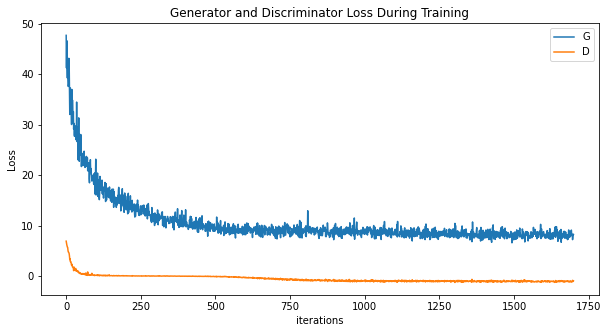

In [290]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [300]:
netG.eval()
for i, (real_past_traj, real_future_traj) in enumerate(train_loader):
    # Format batch
    real_past_traj = real_past_traj.to(device)
    real_future_traj = real_future_traj.to(device)

    # Generate batch of latent vectors
    noise = torch.randn((real_past_traj.size(0),1,36,10), device=device)
    # Generate future traj batch with G
    fake = netG(real_past_traj, noise)
    break

tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([[ 0.3011,  0.2931,  0.2993,  0.3044,  0.3030,  0.2990,  0.2871,  0.2838,
          0.2890,  0.2924],
        [-0.3151, -0.3096, -0.3188, -0.3333, -0.3448, -0.3379, -0.3193, -0.2929,
         -0.3272, -0.3392]], device='cuda:0', grad_fn=<SelectBackward0>) tensor([[ 0.4075,  0.4060,  0.4040,  0.4017,  0.3990,  0.3960,  0.3928,  0.3894,
          0.3859,  0.3823],
        [-0.4580, -0.4562, -0.4539, -0.4511, -0.4478, -0.4442, -0.4401, -0.4358,
         -0.4310, -0.4259]], device='cuda:0')


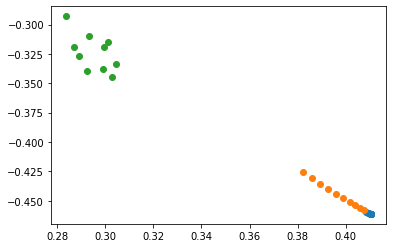

In [301]:
real_past_traj = real_past_traj.to(device)
real_future_traj = real_future_traj.to(device)

# Generate batch of latent vectors
noise = torch.randn((real_past_traj.size(0),1,36,10), device=device)
# Generate future traj batch with G
fake = netG(real_past_traj, noise)
for i in range(1):
    plt.scatter(real_past_traj[i,0,0].to("cpu").numpy(), real_past_traj[i,1,0].to("cpu").numpy())
    plt.scatter(real_future_traj[i,0,0].to("cpu").numpy(), real_future_traj[i,1,0].to("cpu").numpy())
    plt.scatter(fake[i,0,0].detach().to("cpu").numpy(), fake[i,1,0].detach().to("cpu").numpy())
MSELoss = nn.MSELoss()
print(MSELoss(fake[i,:,:], real_future_traj[i,:,:]))
print(fake[i,:,0], real_future_traj[i,:,0])